# Reverse Engineering what the raw CAN packets mean
Going to leverage data from forscan to see what they mean

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import struct

In [2]:
fnameFORScan = "~/car/CANDumps/steeringTest_forscan_20180604_01.csv"
fnameSavvyCAN = "~/car/CANDumps/steeringTest_SavvyCAN_20180604_01.csv"

In [44]:
def readFORScan(fname):
    ''' 
    read a forscan output file to a dataframe
    # format is:
    | time[ms] | DATA1 | DATA2 | ... | DATA3 |
    |  <time>  | <val> | <val> | ... | <val> |
    '''
    
    delimiters = [",",";"]
    for delim in delimiters:
        try:
            data = pd.read_csv(fnameFORScan,delimiter=delim)
            break
        except:
            print("Delimiter is not {}".format(delim))

    #clean up column names
    newCols = {}
    for col in data.columns:
        loc = col.find("(")
        if loc > 0:
            newCols.update({col:col[:loc]})
    data = data.rename(index=bytes,columns=newCols)
    data = data[data.time>1000] # eliminate the first second of data, may have bad values
    data = data.reset_index(drop=True) # reset the inde
    for c in cols:
        if data[c][0] == "Off" or data[c][0] == "On":
            data[c][data[c] == "Off"] = 0
            data[c][data[c] == "On"] = 1

    data = data.astype(np.float32)
    data["time"] = data.apply(lambda row: row["time"]/1e3,axis=1)
    return data

def readSavvyCAN(fname):
    '''
    read the savvycan dump to a dataframe
    '''
    dtype = {'Time Stamp':np.float32, 'ID':bytes, 'Extended':bool, 'Dir':str, 'Bus':int, 'LEN':int,
                            'D1':bytes, 'D2':bytes, 'D3':bytes,'D4':bytes, 'D5':bytes, 'D6':bytes, 'D7':bytes, 'D8':bytes}
    data = pd.read_csv(fname,index_col=False,dtype=dtype)# savvycan adds extra comma at end of line
    
    def convertToBytes(x):
        return bytes.fromhex(x)
    for col in ["ID","D1","D2","D3","D4","D5","D6","D7","D8"]:
        data[col] = data.apply(lambda row: convertToBytes(row[col]),axis=1)
        
    minVal = data["Time Stamp"].min()/1e6
    
    data["Time Stamp"] = data.apply(lambda row: row["Time Stamp"]/1e6-minVal,axis=1)

    return data

In [45]:
def convertTo_int8(data):
    '''
    Convert bytes into signed 8bit integer values
    '''
    length = len(data)
    
    return struct.unpack(length*"b",data)

def convertTo_uint8(data):
    '''
    Convert bytes into un-signed 8bit integer values
    '''
    length = len(data)
    return struct.unpack(length*"B",data)

def convertTo_int16(data):
    '''
    Convert 2 bytes into signed 16bit integer values
    '''
    return struct.unpack("h",data)[0]

In [46]:
dff = readFORScan(fnameFORScan)
dfs = readSavvyCAN(fnameSavvyCAN)

/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Steering Angle
ID: \x738    Data: \x05 \x62 \x33 \x02

Convert by: struct.unpack("h",byte6 + byte5)[0]/30

Units: Degrees

min: -523.5999755859375 max: 409.0


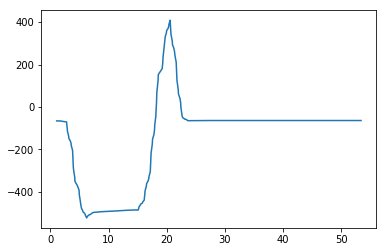

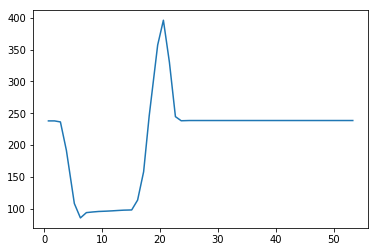

In [47]:
# filter by steering angle
angle = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x02")]
angle = angle.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_ANG"].min(),dff["STR_ANG"].max()))
plt.plot(dff["time"],dff["STR_ANG"])
plt.show()

d = angle.apply(lambda row: convertTo_int16(row["D6"]+row["D5"]),axis=1)
d = d/30
plt.plot(angle["Time Stamp"],d)
plt.show()

# Steering Torque
ID: \x738    Data: \x04 \x62 \x33 \x0B

Convert by:(struct.unpack("B",byte5)[0]-127)/10

Units: N*m

min: -6.699999809265137 max: 7.400000095367432


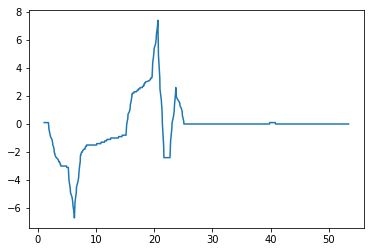

min: -6.7 max: 7.4


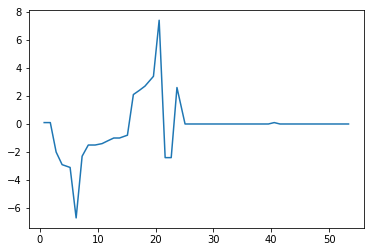

In [48]:
# filter by steering angle
torque = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x0b")]
torque = torque.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_TRQ_S_M"].min(),dff["STR_TRQ_S_M"].max()))
plt.plot(dff["time"],dff["STR_TRQ_S_M"])
plt.show()

t = torque.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
t = (t-127)/10
print("min: {} max: {}".format(t.min(),t.max()))
plt.plot(torque["Time Stamp"],t)
plt.show()

# Steering Speed
## It looks like the numbers are likely too small for FORScan to output by default
ID: \x738    Data: \x04 \x62 \x33 \x01

Convert by:

Units: rev/min


min: 0.0 max: 0.0


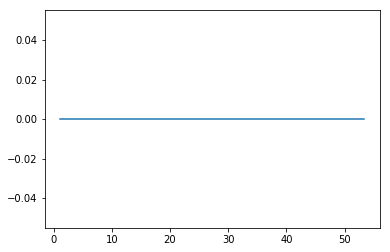

min: 0 max: 110


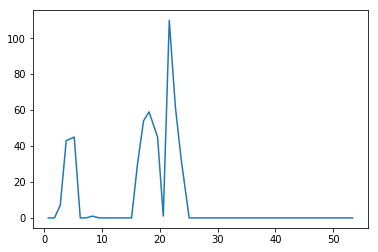

In [49]:
speed = dfs[(dfs["ID"]==b"\x00\x00\x07\x38") & (dfs["D1"]==b"\x04")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\x33")& (dfs["D4"]==b"\x01")]
speed = speed.reset_index(drop=True)

print("min: {} max: {}".format(dff["STR_ROT_SPD"].min(),dff["STR_ROT_SPD"].max()))
plt.plot(dff["time"],dff["STR_ROT_SPD"])
plt.show()

s = speed.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
print("min: {} max: {}".format(s.min(),s.max()))
plt.plot(torque["Time Stamp"],s)
plt.show()

In [50]:
fnameFORScan = "~/car/CANDumps/steeringTest_forscan_20180524_01.csv"
fnameSavvyCAN = "~/car/CANDumps/steeringTest_SavvyCAN_20180524_01.csv"
dff = readFORScan(fnameFORScan)
dfs = readSavvyCAN(fnameSavvyCAN)

/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/neil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
dff[:10]

,time,BRK_F_P_C,BRK_F_P_R,STR_ANG,STR_ANG_EST,STR_ROT_SPD,STR_TRQ_S_M,STR_TRQ_S_S,TURN_SW_L,TURN_SW_R,TACHOMTR,TP,TP_REL
0,1.084,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
1,1.123,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
2,1.371,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
3,1.482,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
4,1.531,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
5,1.676,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,2.35
6,1.776,0.0,0.0,-65.900002,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,1.96
7,1.812,0.0,0.0,-66.300003,0.0,0.0,0.1,0.0,0.0,0.0,500.0,11.37,1.96
8,1.853,0.0,0.0,-66.699997,0.0,0.0,-0.1,0.0,0.0,0.0,500.0,11.37,1.96
9,1.891,0.0,0.0,-67.099998,0.0,0.0,-0.2,-0.2,0.0,0.0,500.0,11.37,1.96


# Turn Signal 
ID: \x739    Data: \x05 \x62 \xD9 \x80

Convert by:
  * None On: byte5 == b'\x10'
  * Left:    byte5 == b'\x11'
  * Right:   byte5 == b'\x12'

Units: Bool


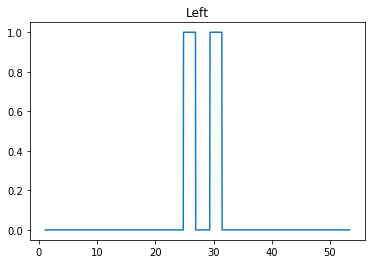

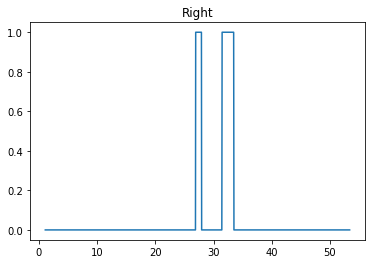

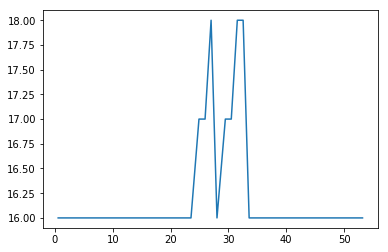

Unique values for signal: [b'\x10' b'\x11' b'\x12']


In [82]:
signal = dfs[(dfs["ID"]==b"\x00\x00\x07\x39") & (dfs["D1"]==b"\x05")& (dfs["D2"]==b"\x62")& (dfs["D3"]==b"\xD9")& (dfs["D4"]==b"\x80")]
signal = signal.reset_index(drop=True)

plt.plot(dff["time"],dff["TURN_SW_L"])
plt.title("Left")
plt.show()
plt.plot(dff["time"],dff["TURN_SW_R"])
plt.title("Right")
plt.show()


s = signal.apply(lambda row: convertTo_uint8(row["D5"])[0],axis=1)
plt.plot(signal["Time Stamp"],s)
plt.show()
print("Unique values for signal: {}".format(signal["D5"].unique()))

In [ ]:
data.to_csv()